In [2]:
"""
TODO:

17.group per events , users ✓ 
18.columns to drop ✓
19.target encoding city region ✓

* Subs
* events
*
* NN @keras
* features 
* hyperpar tune + grid search // random search
* 
* cat cols with catboost &lgbm
*pep8

""";

In [3]:
import os
import time
import numpy as np
import pandas as pd
import datetime

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef as mcc

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 65)
pd.set_option('display.max_columns', 55)

C:\Users\python\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [63]:
printHeads = 0
plotGraphs = 0

In [64]:
if printHeads:
    display(os.listdir())

In [65]:
if printHeads and 0:
    csvs = (x for x in os.listdir() if x.endswith('.csv'))
    for a in csvs:
        print(a)
        display(pd.read_csv(a,nrows = 5).head(3))
        print("-----------------"*7)

In [66]:
Loadcsvs = 1
if Loadcsvs:
    train_accounts = pd.read_csv('train_accounts.csv',parse_dates=[2,4,5,10],index_col=[0])
    train_users = pd.read_csv('train_users.csv',parse_dates=[4,8])
    #train_events = pd.read_csv('train_events',parse_dates=[0]) 
    train_subscriptions = pd.read_csv('train_subscriptions.csv')

    #test
    test_accounts = pd.read_csv('test_accounts.csv',parse_dates=[2,4,5,10],index_col=[0])
    test_users = pd.read_csv('test_users.csv',parse_dates=[4,8])
    #test_events = pd.read_csv('test_events.csv',parse_dates=[0])
    test_subscriptions = pd.read_csv('test_subscriptions.csv')

C:\Users\python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\python\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [67]:
# dataframe info stats
def stats(data):
    
    maxx = []
    minn = []
    for i in data.columns:
        maxx.append(data[i].value_counts().max())
        minn.append(data[i].value_counts().min())

    return pd.DataFrame(
        {'nunique': data.nunique(),
         'len': len(data),
         'nunique/len': data.nunique()/len(data),
         'types':data.dtypes,
         'Nulls' : data.isna().sum(),
         'Nullpercent' : data.isna().sum()/len(data),
         "Value counts Max": maxx,
         'Value counts Min':minn 
        },
        columns = ['nunique', 'len', 'nunique/len','types','Nulls',
                   'Nullpercent',"Value counts Max",'Value counts Min']).\
        sort_values(by ='nunique',ascending = False)

In [68]:
# values in test not exist in train 
def traintestdiffs(df_train,dt_test,numofunique=100):
    for x in dt_test.columns:
        if (df_train[x].nunique() < numofunique):
            if np.setdiff1d(dt_test[x].astype(str).unique(),df_train[x].astype(str).unique()).size > 0 :
                print(x," ::: ",np.setdiff1d(dt_test[x].astype(str).unique(),df_train[x].astype(str).unique()))

# accounts

In [69]:
if printHeads:
    display(stats(train_accounts))

In [70]:
if printHeads:
    display(train_accounts.head().T)

In [71]:
if plotGraphs:
    print(train_accounts.lead_score.value_counts())
    train_accounts['lead_score'].value_counts().plot(kind = 'bar',figsize = (4, 4))

In [72]:
if plotGraphs:
    train_accounts['max_team_size'].hist(figsize = (4, 4))
    plt.show()

In [73]:
if plotGraphs:
    sns.set(rc={'figure.figsize':(6,6)})
    ax = sns.countplot(x="os", data=train_accounts, hue = 'lead_score',
                       order=train_accounts['os'].value_counts().iloc[:6].index)

In [74]:
# check unique values in object type columns
if printHeads:
    for x in train_accounts.columns:
        if (train_accounts[x].nunique() < 100 and train_accounts[x].dtype == 'O'):
            print (x," -- " ,train_accounts[x].unique())

In [75]:
def prepro(df,targetenco = False):
    
    
    if targetenco:
        def targetenc(df,column):
            #lead score only in train data 
            oss = train_accounts.groupby(column)['lead_score'].agg(['sum','count']).sort_values(('count'),ascending=False)
            oss['Lead_score_rate'] = oss['sum']/oss['count']
            d = dict(zip(oss.index,oss.Lead_score_rate))
            df[column] = df[column].map(d).fillna(0)
            return df

        #df = targetenc(df,'country')
        df = targetenc(df,'os')
    
    else:
        catcols = ['region', 'country']
        df = df.drop(catcols,axis = 1)
        
    
#acc drop cols
    
    ToDrop = ['account_name','has_logo']
    df = df.drop(ToDrop,axis = 1)
    
#fillna
    
    # churn date not null but reason yes => missing reason fill 0
    df.loc[df['churn_date'].notnull() & df['churn_reason'].isna(), 'churn_reason'] = 0

    # churn date and reason  null => didnt churned -1/-99
    df.loc[df['churn_date'].isna() & df['churn_reason'].isna(), 'churn_reason'] = -1
    
    #fill -1
    MinusOne = ['plan_id','max_team_size', 'min_team_size','mrr','company_size']
    df[MinusOne] = df[MinusOne].fillna(-1)
    
    # started at check
    df['churn_date'] = df['churn_date'].fillna(value=pd.to_datetime('1/1/2020'))
    df['subscription_started_at'] = df['subscription_started_at'].fillna(value=pd.to_datetime('1/1/2010'))

    # fill unknown
    unknowncols = ['browser','os','utm_cluster_id','industry','payment_currency','user_goal','user_description']
    df[unknowncols] = df[unknowncols].fillna('UnKnown')
    
    # cat to numbers -- team size
    TsDict = {
    
                '0':0,
                '2':2,
                '2-5':3.5,
                '4':4,
                '8':8,
                '6-10':8.1,
                '11-15':13.1,
                '16-25':20.5,
                '26-50':38.1,
                '51-100':75.5, 
                '101-500':300.5,
                '500 ':500,
                np.nan:-7
            }
    TsDict.update(dict.fromkeys(['1', '1-1', 'Solo yo','Moi uniquement','Nur ich','Apenas eu'],1))
    df['team_size'] = df['team_size'].map(TsDict).fillna(df['team_size']).astype('float64')
    
# date to int 
    
    datecols = ['created_at','trial_start','churn_date','subscription_started_at']
    for col in datecols:
        df[col] = pd.to_datetime(df[col]).astype(np.int64)
    
    # ToDo change (50)
    df['time_diff'] = df['time_diff'].fillna(50)
    
# create dummies 
    
    ColsToDummy = ['device','os','browser','payment_currency','industry','utm_cluster_id','user_goal','user_description','team_size']
    #df = pd.get_dummies(df, columns=ColsToDummy)
    
    return df


train_accounts_pr = prepro(train_accounts)
test_accounts_pr = prepro(test_accounts)
print('done');

done


# users

In [76]:
if printHeads:
    display(stats(train_users))

In [77]:
def usersprepro(df):
    
#users drop cols
    
    ToDrop = ['has_phone','has_photo','email','country','serial_number','region','city','name']
    df = df.drop(ToDrop,axis = 1)
    
#fillna

    # fill unknown
    unknowncols = ['device','os','browser','seniority','language']
    df[unknowncols] = df[unknowncols].fillna('UnKnown')
    
    #fill data na TODO : change 112020
    df['became_active_at'] = df['became_active_at'].fillna(value=pd.to_datetime('1/1/2020'))
    df['Created_Active_delta'] = (df['became_active_at']-df['created_at'])
    
    #date to int ## TODO : check 
    datecols = ['created_at','became_active_at']
    for col in datecols:
        df[col] = pd.to_datetime(df[col]).astype(np.int64)
    
    # ToDo change (50)
    df['time_diff'] = df['time_diff'].fillna(50)
    
    # create dummies
    ColsToDummy = ['device','os','browser','seniority','language']
    #df = pd.get_dummies(df, columns=ColsToDummy)
    
    
    return df

train_users_pr = usersprepro(train_users)
test_users_pr = usersprepro(test_users)
print('Done')

Done


In [78]:
if printHeads:
    display(stats(train_users_pr))

In [79]:
# check unique values in object type columns
if printHeads:
    for x in train_users.columns:
        if (train_users[x].nunique() < 100 and train_users[x].dtype == 'O'):
            print (x," -- " ,train_users[x].nunique())

In [80]:
if printHeads:
    display(train_users_pr.head().T)

In [81]:
# group users by account
def groupusers(df):
    
    # get admin id for each account , if more than one take first
    admins = df[['account_id','user_id']][df.is_admin==1]\
        .set_index('account_id').add_prefix('admin_')
    # For now TODO 
    admins = admins[~admins.index.duplicated(keep='first')]
    
    # get first user for each account
    first_user_per_account = df[['account_id','user_id','became_active_at']].\
        sort_values(by=['account_id','user_id','became_active_at'],ascending = True).\
        groupby('account_id').first().add_prefix('first_')

    # group users per account
    grouped_df = df.groupby(by='account_id')\
                .agg({'user_id':['count'],
                      'became_active_at':['min','max'],
                      'Created_Active_delta':['min','max'],
                      'created_at':['min','max'],
                      'enabled':['mean','max'],
                      'is_admin':['mean'],
                      })
    grouped_df.columns = ['_'.join(col) for col in grouped_df.columns]
    
    # merge 
    merged = grouped_df.merge(admins,left_index=True,right_index=True,how = 'inner',validate="1:1")\
              .merge(first_user_per_account,left_index=True,right_index=True,how = 'inner',validate="1:1")
    # TODO check
    colsToUse = ['user_id_count', 'became_active_at_min', 'became_active_at_max',
       'Created_Active_delta_min', 'Created_Active_delta_max',
       'created_at_min', 'created_at_max', 'enabled_mean', 'enabled_max',
       'is_admin_mean', 
       'first_became_active_at']
    
    merged = merged[colsToUse]
    return merged


train_users_gr= groupusers(train_users_pr)
print(len(train_users_gr))
test_users_gr= groupusers(test_users_pr)
print(len(test_users_gr))

print('done')

1308854
68822
done


# events

Events csv file too large.
I Load it in other notebook (events.ipynb). group it by account and user and export it to smaller csv.
Here i load the grouped csv.

In [82]:
train_events_gr_usr = pd.read_csv('train_events_gr_usr.csv',parse_dates=[26,27])
test_events_gr_usr = pd.read_csv('test_events_gr_usr.csv',parse_dates=[26,27])

In [83]:
if printHeads:
    display(train_events_gr_usr.head().T)

In [84]:
if printHeads:
    display(stats(train_events_gr_usr))

### group per account

In [85]:
# group events from per account-user to account
def eventsperaccount(df):
    
    #sum all numeric values per account
    accounts_events_sum = df.groupby('account_id').sum().drop('user_id',axis=1)
    
    #group Non-sum features
    accounts_evenst_dates = df.groupby(by=['account_id'])\
                .agg({ 'max_date':['max'],
                      'min_date':['min'],
                      'nunique_date':['max','min','mean'],
                      'UsageLength':['max','min','mean'],
                      'user_id':['nunique']
                      })
    accounts_evenst_dates.columns = ['_'.join(col) for col in accounts_evenst_dates.columns]    
    
    #rename columns
    Names = {"max_date_max":"max_event_date",
         "min_date_min":"min_event_date",
         "user_id_nunique":"numOfusers"}
    accounts_evenst_dates.rename(columns=Names,inplace=True)

    #join both DataFrames
    merged_acc_events = accounts_events_sum.merge(accounts_evenst_dates,how='inner',left_index=True,right_index=True,validate='1:1')
    
    #time to int TODO:check
    datecols = ['max_event_date','min_event_date']
    for col in datecols:
        merged_acc_events[col] = pd.to_datetime(merged_acc_events[col]).astype(np.int64)
        
    return merged_acc_events


train_events_gr_acc = eventsperaccount(train_events_gr_usr)
test_events_gr_acc = eventsperaccount(test_events_gr_usr)
print('done')

done


# subscriptions

In [86]:
if printHeads:
    display(train_subscriptions.head().T)

In [87]:
if printHeads:
    display(stats(train_subscriptions))

In [88]:
#preprocessing for subscription TODO
def subsprepro(df):
    start_time = time.time()
    
    #group by account #TODO currency,payment type
    subsGrouped  = df.groupby(by='account_id')\
                .agg({'invoice_charge_amount':['sum'],
                      'event_type':['nunique'],
                      'mrr_gain':['sum'],
                      'event_happened_at':['min','max','count']
                      #'currency':pd.Series.mode,
                      #'payment_type':pd.Series.mode
                      });
    subsGrouped.columns = ['_'.join(col) for col in subsGrouped.columns]
    
    
    #subsGrouped = pd.get_dummies(subsGrouped,columns = ['currency_mode', 'payment_type_mode'])
    
    print (time.time()-start_time,' Seconds')
    return subsGrouped


train_subscriptions_pr = subsprepro(train_subscriptions)
test_subscriptions_pr = subsprepro(test_subscriptions)
print('done')

37.436163663864136  Seconds
2.2174692153930664  Seconds
done


# visualization

In [89]:
if plotGraphs:
    corrmat = train_accounts_pr.corr()
    fig = plt.figure(figsize = (15, 15))

    sns.heatmap(corrmat, square = True)
    plt.show()

In [90]:
if plotGraphs:
    ax = sns.countplot(x="payment_currency", data=train_accounts_pr,hue = 'lead_score',
                       order=train_accounts_pr['payment_currency'].value_counts().iloc[:6].index)

In [91]:
if plotGraphs:
    ax = sns.countplot(x="os", data=train_accounts_pr,hue = 'lead_score',
                       order=train_accounts_pr['os'].value_counts().iloc[:6].index)

## merge tables 

In [92]:
#drop duplicates
train_accounts_pr = train_accounts_pr.loc[~train_accounts_pr.index.duplicated(keep='first')]

#train
panel_train = train_accounts_pr.merge(train_users_gr,left_index=True,right_index=True,how = 'inner',validate="1:1").\
                                merge(train_events_gr_acc,left_index=True,right_index=True,how = 'inner',validate="1:1").\
                                merge(train_subscriptions_pr,left_index=True,right_index=True,how = 'left',validate="1:1")

#test
panel_test = test_accounts_pr.merge(test_users_gr,left_index=True,right_index=True,how = 'inner',validate="1:1").\
                            merge(test_events_gr_acc,left_index=True,right_index=True,how = 'inner',validate="1:1").\
                            merge(test_subscriptions_pr,left_index=True,right_index=True,how = 'left',validate="1:1")

#after join fillna in subscription dafaframe
colstofill = train_subscriptions_pr.columns.values

panel_train[colstofill] = panel_train[colstofill].fillna(0,axis=1)
panel_test[colstofill] = panel_test[colstofill].fillna(0,axis=1)

In [93]:
if printHeads:
    display(panel_train.info())

In [94]:
# train eval split
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']

y = panel_train['lead_score']
X = panel_train.select_dtypes(include=numerics).drop('lead_score',axis = 1)


X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=17) ## test_size = 0.000001

# test split

X_test = panel_test.select_dtypes(include=numerics)

# Fit model

In [95]:
"""
X_train
X_val
y_train
y_val

---------
X_test
y_pred

""";

In [96]:
def printMetrics(test,prediction):
    
    print(confusion_matrix(test, prediction))
    print('#'*100)
    print(classification_report(test, prediction))
    
#-----------------------------

def runModel (modelname,X_train, y_train,X_test,y_test,printaccuracy=True):
    
    start_time = time.time()
    
    y_pred = modelname.fit(X_train, y_train).predict(X_test)
    
    if printaccuracy:
        
        print(modelname.__class__.__name__ +' running time : {} seconds '.format(time.time() - start_time ))
        print('Accuracy of '+ modelname.__class__.__name__ +' on training set: {:.3f}'
         .format(modelname.score(X_train, y_train)))
        print('Accuracy of '+ modelname.__class__.__name__ +' on test set: {:.3f}'
         .format(modelname.score(X_test, y_test)))
    
    return y_pred,modelname

In [97]:
XGB = Rf = NB =  1

LGBM = 1

CB = 0

In [98]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

if NB:
# Feature Scaling
    sc_X = StandardScaler()
    X_train_tr = sc_X.fit_transform(X_train)
    X_val_tr = sc_X.transform(X_val)

    classifier = GaussianNB()

    y_pred,Model = runModel(classifier,X_train_tr, y_train,X_val_tr,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    NB_mcc = mcc(y_val, y_pred)
    y_NB = y_pred.copy()

GaussianNB running time : 5.553636312484741 seconds 
Accuracy of GaussianNB on training set: 0.937
Accuracy of GaussianNB on test set: 0.937
####################################################################################################
[[243733  11312]
 [  5175   1496]]
####################################################################################################
             precision    recall  f1-score   support

          0       0.98      0.96      0.97    255045
          1       0.12      0.22      0.15      6671

avg / total       0.96      0.94      0.95    261716



In [99]:
# RF
if Rf:
   
    RFC = RandomForestClassifier(random_state=17)
    y_pred,Model = runModel(RFC,X_train, y_train,X_val,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    RF_mcc = mcc(y_val, y_pred)
    y_RF = y_pred.copy()
    RFModel = Model

RandomForestClassifier running time : 219.43609142303467 seconds 
Accuracy of RandomForestClassifier on training set: 0.998
Accuracy of RandomForestClassifier on test set: 0.978
####################################################################################################
[[254229    816]
 [  4883   1788]]
####################################################################################################
             precision    recall  f1-score   support

          0       0.98      1.00      0.99    255045
          1       0.69      0.27      0.39      6671

avg / total       0.97      0.98      0.97    261716



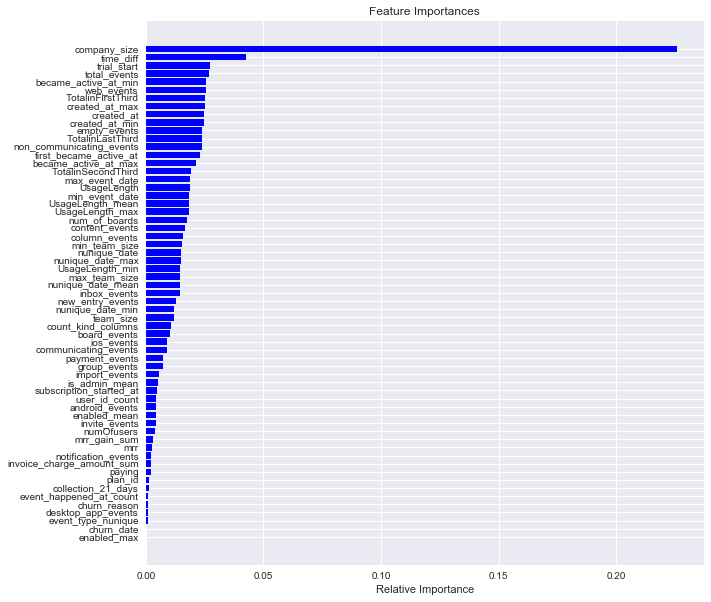

In [100]:
if Rf:
    features=X_train.columns
    importances = RFC.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10,10))
    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')

In [101]:
import xgboost as xgb

if XGB:
   
    gbm = xgb.XGBClassifier(random_state=17)
    y_pred,Model = runModel(gbm,X_train, y_train,X_val,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    print(mcc(y_val, y_pred))
    y_XGB = y_pred.copy()
    XGBModel = Model

C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier running time : 647.5072591304779 seconds 


C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy of XGBClassifier on training set: 0.979


C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy of XGBClassifier on test set: 0.979
####################################################################################################
[[254261    784]
 [  4815   1856]]
####################################################################################################
             precision    recall  f1-score   support

          0       0.98      1.00      0.99    255045
          1       0.70      0.28      0.40      6671

avg / total       0.97      0.98      0.97    261716

0.43396054665175643


In [102]:
from catboost import CatBoostClassifier

if CB:
    
    cbc = CatBoostClassifier(random_state=17)
    y_pred,Model = runModel(cbc,X_train, y_train,X_val,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    y_CB = y_pred.copy()

In [103]:
from lightgbm import LGBMModel,LGBMClassifier

if LGBM:
    
    Lgb = LGBMClassifier(random_state=17)
    y_pred,Model = runModel(Lgb,X_train, y_train,X_val,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    print(mcc(y_val, y_pred))
    Y_Lgb = y_pred.copy()
    

C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGBMClassifier running time : 129.52082300186157 seconds 


C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy of LGBMClassifier on training set: 0.981


C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy of LGBMClassifier on test set: 0.980
####################################################################################################
[[253854   1191]
 [  4065   2606]]
####################################################################################################
             precision    recall  f1-score   support

          0       0.98      1.00      0.99    255045
          1       0.69      0.39      0.50      6671

avg / total       0.98      0.98      0.98    261716

0.5087478267681812


# Predict

In [104]:
y_sub = Model.predict(X_test)

C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [105]:
print ("0:" ,np.bincount(y_sub)[0])
print ("1:" ,np.bincount(y_sub)[1])

0: 67805
1: 1010


## leader board results

In [109]:
LoadFroundTruth = 1

if LoadFroundTruth:
    #ground_truth_secret.to_csv('ground_truth_secret.csv') # download file from google colab and save as csv
    ground_truth_secret = pd.read_csv('ground_truth_secret.csv',index_col=[0],header=None)
    #ground_truth_public.to_csv('ground_truth_public.csv') # download file from google colab and save as csv
    ground_truth_public = pd.read_csv('ground_truth_public.csv',index_col=[0],header=None)
    ground_truth_public.index = ground_truth_public.index.astype('int64').astype('str')
    ground_truth_secret.index = ground_truth_secret.index.astype('int64').astype('str')
    
    
if 1:
    
    #prediction to results format:
    
    prediction_series = pd.Series(y_sub,index = X_test.index.astype('int64').astype('str')).rename("lead_score")
    
    if ground_truth_public.index.isin(prediction_series.index).any():
        public_prediction = prediction_series[ground_truth_public.index]
    
    public_prediction = public_prediction.fillna(0).astype('int')

    if ground_truth_secret.index.isin(prediction_series.index).any():
        secret_prediction = prediction_series[ground_truth_secret.index]

    secret_prediction = secret_prediction.fillna(0).astype('int')
    
   

    print (mcc(ground_truth_public, public_prediction),
              mcc(ground_truth_secret, secret_prediction))
    print('--'*17)
    print ("AVG : " , (mcc(ground_truth_public, public_prediction)+
              mcc(ground_truth_secret, secret_prediction))/2)

0.522414421819635 0.5180755442329399
----------------------------------
AVG :  0.5202449830262874


## bagging

In [107]:
bag = 1
testbag = 1


if testbag:
    y_XGB = XGBModel.predict(X_test)
    y_RF = RFModel.predict(X_test)
    Y_Lgb = Model.predict(X_test)
    
    
    
if bag:
    AA = pd.DataFrame(data = {"XGB":y_XGB,"RF":y_RF,"LGBM":Y_Lgb})
    AA['Sum'] = AA.sum(axis = 1).astype("int")
    AA['Sum/3'] = AA['Sum']/3
    print(len(AA[AA['Sum/3']>0.2]))
    print(len(AA[AA['Sum/3']>0.7]))

C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1288
354


In [108]:
if not testbag and bag:
    y_pred = (AA['Sum/3']>0.2).values*1
    print(mcc(y_val, y_pred))

if testbag:
    y_sub = (AA['Sum/3']>0.2).values*1   

# results log

In [110]:
try :
    Logs = pd.read_excel("log.xlsx",index_col=[0])
    display(Logs.head())
except :
    Logs = pd.DataFrame()
    print("file not exist")

,TrainShape,TestShape,ModelName,0 Value,1 Value,Notes,Score,LeaderBoardScore,RF_mcc,NB_mcc
0,"(1089580, 15)","(272396, 15)",LGBMClassifier,270655,1741,Baseline,0.327996,0.287897,0.314285,0.144054
1,"(1047083, 24)","(261771, 24)",LGBMClassifier,259476,2295,Users Baseline,0.353634,0.308732,0.296800,0.144061
2,"(1046863, 58)","(261716, 58)",LGBMClassifier,257904,3812,events Baseline,0.503231,0.483097,0.392189,0.137709
3,"(1046863, 62)","(261716, 62)",LGBMClassifier,257934,3782,subs Baseline,0.503521,0.471862,0.395821,0.131522
4,"(1046863, 61)","(261716, 61)",LGBMClassifier,257919,3797,bagging <0.2,0.508748,0.520245,0.420534,0.131425


In [111]:
import datetime
log = pd.DataFrame()
log.loc[0,'TrainShape'] = str(X_train.shape)
log.loc[0,'TestShape'] = str(X_val.shape)
log.loc[0,'ModelName'] = Model.__class__.__name__
log.loc[0,'0 Value'] = np.bincount(y_pred)[0]
log.loc[0,'1 Value'] = np.bincount(y_pred)[1]
log.loc[0,'Notes'] = " bagging <0.2"
log.loc[0,'Score'] = mcc(y_val, y_pred)
log.loc[0,'LeaderBoardScore'] = (mcc(ground_truth_public, public_prediction)+mcc(ground_truth_secret, secret_prediction))/2
log.loc[0,'RF_mcc'] = RF_mcc
log.loc[0,'NB_mcc'] = NB_mcc

In [112]:
Logs.append(log).reset_index(drop=True).tail()

,TrainShape,TestShape,ModelName,0 Value,1 Value,Notes,Score,LeaderBoardScore,RF_mcc,NB_mcc
1,"(1047083, 24)","(261771, 24)",LGBMClassifier,259476.0,2295.0,Users Baseline,0.353634,0.308732,0.296800,0.144061
2,"(1046863, 58)","(261716, 58)",LGBMClassifier,257904.0,3812.0,events Baseline,0.503231,0.483097,0.392189,0.137709
3,"(1046863, 62)","(261716, 62)",LGBMClassifier,257934.0,3782.0,subs Baseline,0.503521,0.471862,0.395821,0.131522
4,"(1046863, 61)","(261716, 61)",LGBMClassifier,257919.0,3797.0,bagging <0.2,0.508748,0.520245,0.420534,0.131425
5,"(1046863, 61)","(261716, 61)",LGBMClassifier,257919.0,3797.0,bagging <0.2,0.508748,0.520245,0.420534,0.131425


In [62]:
if 1 : #input("insert score ")=='y':
    Logs.append(log).reset_index(drop=True).to_excel("log.xlsx")

In [ ]:
raise Exception ("End")